In [8]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
#%matplotlib notebook
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
#%matplotlib widget

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


0.5147065290344688 0.5147065290344688 nan NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits
() (18, 400, 488)
0.4623968366579217 0.4623968366579217 nan NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits
() (16, 400, 488)
0.5632243321990833 0.5632243321990833 nan NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits
() (9, 400, 488)
0.7263944698070224 0.7263944698070224 nan NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits
() (64, 400, 488)
0.39852470671032636 0.39852470671032636 nan SiJ2_1.cube.reproject.K-kms.pbcor.fits
() (122, 400, 488)
0.38723203530810885 0.38723203530810885 nan H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits
() (123, 400, 488)
0.3379113118479168 0.3379113118479168 nan CCH_N1.cube.reproject.K-kms.pbcor.fits
() (3, 400, 488)
0.7241851875952677 0.7241851875952677 nan HC3N_J11.cube.reproject.K-kms.pbcor.fits
() (122, 400, 488)
0.6885166764259338 0.6885166764259338 nan NGC_H13CN.cube.reproject.K-kms.pbcor.fits
() (17, 400, 488)
0.23740431666374207 0.23740431666374207 nan NGC_HCO_Plus.cube.K-kms.pbc

IndexError: list index out of range

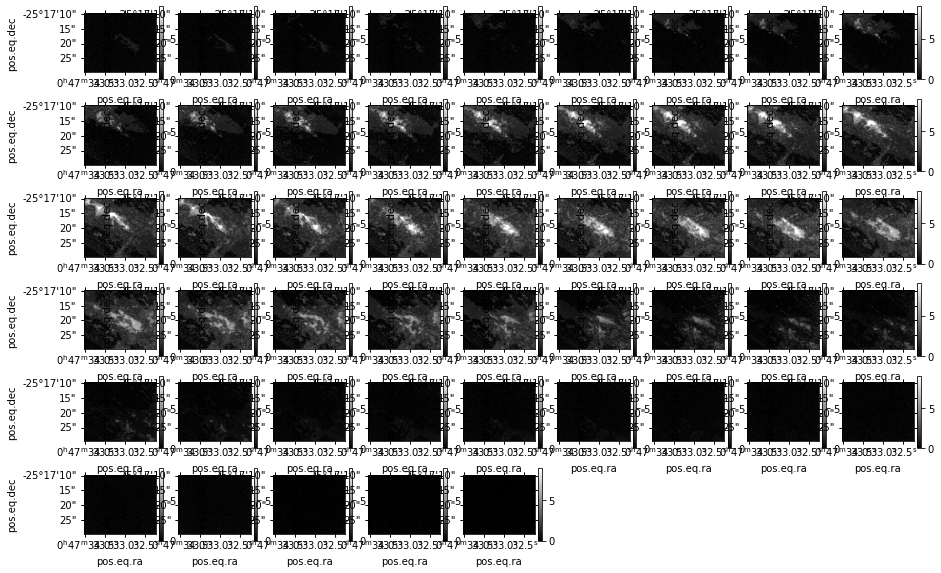

In [9]:
#Find Noise and Confidence, if needed

#Create a mask for all the cubes. 

###################No #If there is another cube that shares at least 67% of the structure, a structure is not to be masked.

#If there are two pixels that have greater than (some) sigma emission we will keep them (at most  (1-P)**2 chance of incorrect label)

#Assign greater confidence to more overlaps


paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
FP = pylab.array(['HCOp_J1-0.cube.fits','HCN_J1-0.cube.fits','H13CN_J1-0.cube.fits','ngc253_co32_hires_common.fits',"SiO_2_1.fits",  "H13CO_Plus_1_0.fits",'CCH_N1-0.cube.fits',"HC3N_11_10.fits",'NGC253.H13CN_4-3.pbcor.fits','NGC253.HCO+_4-3.pbcor.fits','NGC253.HCN_4-3.pbcor.fits'])





SCWs=[]
cds=[]
Ns = [] #get sigmas for all cubes
#Absorbtion_mask="Yes"
Absorbtion_mask="No"

#Find noises for first cubes
for i in range(len(FP)):
    sc = SpectralCube.read(paths[i])#FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise 
    Np1 = SkyCoord('00h47m33.0s', '-25d17m32s', frame='icrs')#These are away from the clusters
    Np2 = SkyCoord('00h47m31.0s', '-25d17m20s', frame='icrs')
    NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
    NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
    
        
    
    no = 3
    m=0
    while(True):

        Q = sc_K_kms[int(len(sc_K_kms)-no):len(sc_K_kms),:,:]#NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]] # Make a subcube away from the signals
        Nsc1 = Q.unmasked_copy()

        if(Absorbtion_mask=="Yes"):
            bp = np.where(Nsc1.hdu.data<0)
            Nsc1.hdu.data[bp]=np.nan
        
            
        #Find StandardDev of this noise cube
        #m=Nsc1.std(axis=0)/u.K
        m=Nsc1.std()/u.K
        
        no+=1
        if(float(np.nanmax(m))!=0.0 and str(float(np.nanmax(m))) != str(np.nan)):
            print(float(np.nanmax(m)),str(float(np.nanmax(m))), str(np.nan),paths[i])
            break
            
    print(np.shape(m),np.shape(Nsc1))
    
    Ns.append(m)
    
#Find noises for pre-masked cubes

'''
for i in range(len(FP)-3,len(FP)):
    sc = SpectralCube.read(FP[i])  
    
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    sc_slab = sc_kms.spectral_slab(-500. *u.km / u.s, 1000. *u.km / u.s)  # Crop out velocities we don't care about    
    sc_slab.allow_huge_operations=True    
    
    sc_K_kms = sc_slab.to(u.K)
    
    scW = sc_K_kms.wcs[:][:][0]

    #Find Noise. Should be the minimum value since it must be at least 3 sigma to be unmasked
    
    Nsc1 = sc_K_kms.unmasked_copy()
    
    
    bp = np.where(Nsc1.hdu.data<=0)
    
    Nsc1.hdu.data[bp]=np.nan
    m=np.nanmin(Nsc1)/u.K
    print(m,np.shape(Nsc1))
    Ns.append(m)
'''  
    
#print(Ns)

for i in range(1):
    cube=SpectralCube.read(paths[i])
    #print(cube.max(axis=0)[0][0]/u.K,Ns[i][0][0])
    #spatial_mask = cube.max(axis=0)/u.K > 3*Ns[i]        
    
    #cubeM = cube.with_mask(spatial_mask)
    #print(np.shape(cube),np.shape(cubeM))
    cd = cube.hdu.data
    #cds.append(cd)
    #print(len(cds))
    #SCWs.append(cube.wcs[:][:][0])

Confidences=cd

pix = np.where(Confidences != 0)
Confidences[pix] = 0 
#print(Confidences.shape)
print(len(paths),len(FP),len(cds),len(Ns))

for i in range(len(paths)):
    cube=SpectralCube.read(paths[i])
    
    cd = cube.hdu.data
    if(Absorbtion_mask=="No"):
        GP = np.where(abs(cd)>Ns[i]*2)#No abs for only emission
    if(Absorbtion_mask=="Yes"):
        GP = np.where(cd>Ns[i]*2)#No abs for only emission
    print(np.shape(GP))
    print(len(Confidences))
    Confidences[GP]+=1

print(Confidences.shape)


   
print(Confidences.shape)


np.save('Confidence_data',Confidences)
np.save('Noises_K',Ns)
#Create a plot of all the confidence values

fig1 = pylab.figure(1,figsize=(15,15))


######Moment 0 and Max map
#print(SCWs[0])
#print(Confidences.shape)0
for n in np.arange(0,int(len(Confidences)/5)):   
    
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(9,9,n+1,projection=scW) # We plot them in a grid    
    #im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(np.nanmean(Confidences[n*5:5*n+5],axis=0),cmap='gray',vmin=0,vmax=9)
    cb=pylab.colorbar(im,fraction=0.046,pad=0.04)  
    
'''
ax = pylab.subplot(1,1,1,projection=SCWs[0]) 
RA = ax.coords[0]                                                                  # 
Dec = ax.coords[1]
im = pylab.imshow(Confidences[int(len(Confidences)*.5)],cmap='rainbow')
'''
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(SCWs[0].world_to_pixel(center)[0]),int(scW.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Number of overlaps',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Confidence',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


np.save('Confidence_data',Confidences)
np.save('Noises_K',Ns)

#Define common structures

#for i in range(len(paths)):


In [9]:
#RUN AFTER CMZ IS DONE25


CENames=[1,2,3,4,5,6,7,8,9,10,11]
CCNames=[1,2,3,4,5,6,7,8,9,10,11]

CENames = np.load("C_Exp_Names.npy")
CCNames =  np.load("C_Coef_Names.npy")

In [3]:
c = [[],[],[]]

c[0].append([1,2,3])
c[1].append([1,2,3])
print(c)

[[[1, 2, 3]], [[1, 2, 3]], []]


In [4]:
#HCO+ 4-3

Num=9
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "HCOp-J4-3_Dend_Abs_100_Runs"

NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names",CENames)
np.save("C_Coef_Names",CCNames)
print(NameC)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)

Noises = np.load('Noises_K.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scCrop[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube



scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]



for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*5,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))

    fig = plt.figure(1,figsize=(30,30))

    pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            
            
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))

    poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    
    Exps[0].append(popt[1])
    Exps[1].append(poptB[1])
    Exps[2].append(poptCon[1])
    Coefs[0].append(popt[0])
    Coefs[1].append(poptB[0])
    Coefs[2].append(poptCon[0])
    

    
np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

HCOp-J4-3_Dend_Abs_100_RunsCoef
NGC_HCO_Plus.cube.K-kms.pbcor.fits
0.12999999999999598 arcsec 0.169999999999992 arcsec
8.839999999997895 pix2
(692,)
(682,)
(680,)
(649,)
(684,)
(740,)
(728,)
(681,)
(708,)
(667,)
(676,)
(659,)
(709,)
(731,)
(679,)
(676,)
(699,)
(707,)
(712,)
(726,)
(675,)
(697,)
(679,)
(686,)
(692,)
(706,)
(715,)
(703,)
(720,)
(713,)
(681,)
(687,)
(693,)
(679,)
(687,)
(681,)
(679,)
(677,)
(725,)
(713,)
(692,)
(689,)
(681,)
(701,)
(683,)
(692,)
(684,)
(708,)
(727,)
(709,)
(685,)
(721,)
(708,)
(671,)
(712,)
(688,)
(722,)
(680,)
(680,)
(724,)
(680,)
(676,)
(715,)
(672,)
(706,)
(672,)
(708,)
(711,)
(703,)
(709,)
(713,)
(693,)
(674,)
(701,)
(700,)
(681,)
(684,)
(722,)
(673,)
(697,)
(714,)
(683,)
(682,)
(687,)
(695,)
(697,)
(666,)
(697,)
(709,)
(697,)
(698,)
(713,)
(675,)
(705,)
(729,)
(737,)
(703,)
(719,)
(680,)
(712,)


<Figure size 2160x2160 with 0 Axes>

In [5]:
#HCN 4-3

Num = 10
Ram_Limiter = 1
Name = "HCN4-3_Abs_100_Runs"

NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names",CENames)
np.save("C_Coef_Names",CCNames)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)

Noises = np.load('Noises_K.npy')
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scCrop[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube



scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]



for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*5,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))

    fig = plt.figure(1,figsize=(30,30))

    pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            
            
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))

    poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    
    Exps[0].append(popt[1])
    Exps[1].append(poptB[1])
    Exps[2].append(poptCon[1])
    Coefs[0].append(popt[0])
    Coefs[1].append(poptB[0])
    Coefs[2].append(poptCon[0])
    

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

NGC253_HCN.cube.reproject.K-kms.pbcor.fits
0.12999999999999598 arcsec 0.169999999999992 arcsec
8.839999999997895 pix2
(8982,)
(9018,)
(9014,)
(9060,)
(8995,)
(9063,)
(9053,)
(9028,)
(9140,)
(9086,)
(9108,)
(8982,)
(8934,)
(9000,)
(8960,)
(8958,)
(9007,)
(8976,)
(9065,)
(9033,)
(9088,)
(9075,)
(9002,)
(9102,)
(9004,)
(9006,)
(8964,)
(8971,)
(9146,)
(8995,)
(8930,)
(9081,)
(9057,)
(8919,)
(8962,)
(9079,)
(9050,)
(9149,)
(9000,)
(8982,)
(8958,)
(8985,)
(9079,)
(8933,)
(9047,)
(9011,)
(9095,)
(9074,)
(9086,)
(8964,)
(8995,)
(9046,)
(8970,)
(8934,)
(9060,)
(8960,)
(9025,)
(9052,)
(8987,)
(9077,)
(9068,)
(8938,)
(9128,)
(8921,)
(8929,)
(8983,)
(9118,)
(9020,)
(9103,)
(9036,)
(9115,)
(9107,)
(8960,)
(9093,)
(8982,)
(9026,)
(8967,)
(8996,)
(8957,)
(9087,)
(9026,)
(8983,)
(9079,)
(8958,)
(9071,)
(8914,)
(9002,)
(9061,)
(9159,)
(9114,)
(8993,)
(9049,)
(9036,)
(9041,)
(8992,)
(8965,)
(8991,)
(8961,)
(9080,)
(9050,)


<Figure size 2160x2160 with 0 Axes>

In [12]:
#H13CN 4-3

'''MISSING MASK FOR 4-3
Num = 8
Ram_Limiter = 1
Name = "H13CN4_3_Abs_100_Runs"

NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names",CENames)
np.save("C_Coef_Names",CCNames)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)

Noises = np.load('Noises_K.npy')
H13CN_MASK = np.load('H13CN_MASK_NGC.npy')

m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]
BP = np.where(H13CN_MASK<1) #Mask where HCN is not found >1 sigma
dat = scCrop.hdu.data[:,:,:]
dat[BP]=np.nan
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scCrop[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube



scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]



for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*1,min_npix=15) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))


    pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            
            
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[np.nan,np.nan]
    try:
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    except:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))
    try:
        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    except:
        poptCon, pcovCon =np.nan,np.nan
    try:
        Exps[0].append(popt[1])
        Coefs[0].append(popt[0])
    except:
        Exps[0].append(np.nan)
        Coefs[0].append(np.nan)
    try:
        Exps[1].append(poptB[1])
        Coefs[1].append(poptB[0])
    except:
        Exps[1].append(np.nan)
        Coefs[1].append(np.nan)
    try:
        Exps[2].append(poptCon[1])
        Coefs[2].append(poptCon[0])
    except:
        Exps[2].append(np.nan)
        Coefs[2].append(np.nan)
    del d
    del Mod_Dat
    gc.collect() 

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

NGC_H13CN.cube.reproject.K-kms.pbcor.fits
0.12999999999999598 arcsec 0.169999999999992 arcsec
8.839999999997895 pix2
(5062,)
(5111,)


KeyboardInterrupt: 

In [13]:
#H13COp 1-0


Num = 5
Ram_Limiter = 1
Name = "H13C0p1_0_Abs_100_Runs"

NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names",CENames)
np.save("C_Coef_Names",CCNames)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)

Noises = np.load('Noises_K.npy')
H13COP_MASK = np.load('H13COP_MASK_NGC.npy')


m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]
BP = np.where(H13COP_MASK<1) #Mask where HCO is not found >1 sigma
dat[BP]=np.nan

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scCrop[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube



scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]



for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*3,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))


    pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            
            
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[np.nan,np.nan]
    try:
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    except:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))
    try:
        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    except:
        poptCon, pcovCon =np.nan,np.nan
    try:
        Exps[0].append(popt[1])
        Coefs[0].append(popt[0])
    except:
        Exps[0].append(np.nan)
        Coefs[0].append(np.nan)
    try:
        Exps[1].append(poptB[1])
        Coefs[1].append(poptB[0])
    except:
        Exps[1].append(np.nan)
        Coefs[1].append(np.nan)
    try:
        Exps[2].append(poptCon[1])
        Coefs[2].append(poptCon[0])
    except:
        Exps[2].append(np.nan)
        Coefs[2].append(np.nan)
    del d
    del Mod_Dat
    gc.collect() 

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits
0.20722991228103602 arcsec 0.28256428241730003 arcsec
23.422308583632642 pix2
(109,)
(117,)
(125,)
(126,)
(108,)
(113,)
(125,)
(103,)
(109,)
(118,)
(126,)
(123,)
(129,)
(110,)
(104,)
(114,)
(112,)
(109,)
(108,)
(106,)
(116,)
(116,)
(113,)
(115,)
(116,)
(121,)
(117,)
(117,)
(114,)
(112,)
(113,)
(110,)
(105,)
(133,)
(118,)
(123,)
(116,)
(121,)
(120,)
(120,)
(105,)
(121,)
(116,)
(117,)
(112,)
(123,)
(109,)
(112,)
(112,)
(103,)
(118,)
(119,)
(114,)
(114,)
(122,)
(113,)
(114,)
(105,)
(114,)
(110,)
(113,)
(122,)
(108,)
(114,)
(128,)
(119,)
(120,)
(116,)
(107,)
(107,)
(135,)
(108,)
(123,)
(111,)
(126,)
(109,)
(109,)
(125,)
(112,)
(106,)
(117,)
(117,)
(116,)
(114,)
(120,)
(107,)
(109,)
(118,)
(101,)
(115,)
(111,)
(119,)
(108,)
(119,)
(128,)
(117,)
(114,)
(119,)
(123,)
(114,)


In [15]:
#H13CN 1-0


Num = 2
Ram_Limiter = 1
Name = "H13CN1_0_Abs_100_Runs"

NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names",CENames)
np.save("C_Coef_Names",CCNames)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)

Noises = np.load('Noises_K.npy')
H13COP_MASK = np.load('H13COP_MASK_NGC.npy')


m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]
BP = np.where(H13COP_MASK<1) #Mask where HCO is not found >1 sigma
dat[BP]=np.nan

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scCrop[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube



scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]



for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*3,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))


    pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            
            
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[np.nan,np.nan]
    try:
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    except:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))
    try:
        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    except:
        poptCon, pcovCon =np.nan,np.nan
    try:
        Exps[0].append(popt[1])
        Coefs[0].append(popt[0])
    except:
        Exps[0].append(np.nan)
        Coefs[0].append(np.nan)
    try:
        Exps[1].append(poptB[1])
        Coefs[1].append(poptB[0])
    except:
        Exps[1].append(np.nan)
        Coefs[1].append(np.nan)
    try:
        Exps[2].append(poptCon[1])
        Coefs[2].append(poptCon[0])
    except:
        Exps[2].append(np.nan)
        Coefs[2].append(np.nan)
    del d
    del Mod_Dat
    gc.collect() 

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits
0.193741553900124 arcsec 0.2583761863464 arcsec
20.02328153341261 pix2
(113,)
(108,)
(117,)
(118,)
(105,)
(119,)
(115,)
(114,)
(102,)
(108,)
(101,)
(105,)
(107,)
(107,)
(114,)
(99,)
(98,)
(116,)
(110,)
(115,)
(117,)
(107,)
(112,)
(112,)
(125,)
(101,)
(116,)
(127,)
(107,)
(106,)
(117,)
(120,)
(94,)
(104,)
(101,)
(108,)
(110,)
(116,)
(122,)
(113,)
(118,)
(119,)
(114,)
(108,)
(105,)
(123,)
(115,)
(108,)
(120,)
(118,)
(105,)
(116,)
(112,)
(126,)
(108,)
(100,)
(110,)
(112,)
(112,)
(113,)
(106,)
(134,)
(111,)
(105,)
(112,)
(129,)
(110,)
(116,)
(108,)
(113,)
(121,)
(124,)
(115,)
(106,)
(115,)
(115,)
(121,)
(119,)
(114,)
(111,)
(111,)
(104,)
(102,)
(118,)
(103,)
(126,)
(97,)
(103,)
(98,)
(128,)
(105,)
(128,)
(112,)
(109,)
(121,)
(107,)
(112,)
(110,)
(105,)
(109,)


In [20]:
#HCOp 1-0


Num = 0
Ram_Limiter = 1
Name = "HC0p1_0_Abs_100_Runs"


NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names",CENames)
np.save("C_Coef_Names",CCNames)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)

Noises = np.load('Noises_K.npy')


m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scCrop[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube



scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]



for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*5,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))


    pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            
            
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[np.nan,np.nan]
    try:
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    except:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))
    try:
        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    except:
        poptCon, pcovCon =np.nan,np.nan
    try:
        Exps[0].append(popt[1])
        Coefs[0].append(popt[0])
    except:
        Exps[0].append(np.nan)
        Coefs[0].append(np.nan)
    try:
        Exps[1].append(poptB[1])
        Coefs[1].append(poptB[0])
    except:
        Exps[1].append(np.nan)
        Coefs[1].append(np.nan)
    try:
        Exps[2].append(poptCon[1])
        Coefs[2].append(poptCon[0])
        print(poptCon)
    except:
        Exps[2].append(np.nan)
        Coefs[2].append(np.nan)
    del d
    del Mod_Dat
    gc.collect() 

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits
0.1839043346733 arcsec 0.250526942496108 arcsec
18.429196270990186 pix2
(488,)
[4.48256886 0.73200851]
(478,)
[4.39229126 0.7385041 ]


KeyboardInterrupt: 

In [19]:
#HCN 1-0


Num = 1
Ram_Limiter = 1
Name = "HCN1_0_Abs_100_Runs"


NameE = (Name+"Exp")
NameC = (Name+"Coef")
CENames[Num] = NameE
CCNames[Num] = NameC
np.save("C_Exp_Names",CENames)
np.save("C_Coef_Names",CCNames)
paths = pylab.array(['NGC_HCOP_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits','NGC_H13CN_J1_0.cube.reproject.K-kms.pbcor.fits','NGC_CO_J3_2.cube.reproject.K-kms.pbcor.fits','SiJ2_1.cube.reproject.K-kms.pbcor.fits','H13CoPJ1_0.cube.reproject.K-kms.pbcor.fits','CCH_N1.cube.reproject.K-kms.pbcor.fits','HC3N_J11.cube.reproject.K-kms.pbcor.fits','NGC_H13CN.cube.reproject.K-kms.pbcor.fits','NGC_HCO_Plus.cube.K-kms.pbcor.fits','NGC253_HCN.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]
print(path)

Noises = np.load('Noises_K.npy')


m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()

scCrop = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scW = scCrop.wcs[:][:][0]

dat = scCrop.hdu.data[:,:,:]

cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scCrop[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube



scWCS = scF.wcs[:][:][0]

#Unload all the unimportant vars
del sc
del paths
del scCrop
del dat

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}
metadata['wavelength'] = header["RESTFRQ"]*u.Hz#
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

#All_SigmasL =  np.array([[]])
#All_SigmasB =  np.array([[]])
#All_RadiiL =  np.array([[]])
#All_RadiiB =  np.array([[]])

Exps =  [[],[],[]]
Coefs = [[],[],[]]



for Per in range(100):
    
    rng = np.random.default_rng(Per**2)#make a different seed each time
    
    Mod_Dat = datn + rng.normal(0,m,np.shape(datn)) #add a noramlly distributed noise to the data to see if this affects our results (localized at 0, std = noise)
    
    d = astrodendro.Dendrogram.compute(Mod_Dat,min_delta=m,min_value=m*5,min_npix=50) #The main culprit

    vel,NA,na = scF.world[:,0,0]

    ##Analyze dendograms
    print(np.shape(d))


    pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
    
    radsL=np.array([])
    radsB=np.array([])
    sigmasL=np.array([])
    sigmasB=np.array([])

    for t in d.all_structures: 

        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)

        if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 6):
            
            
            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)


    from scipy.optimize import curve_fit

    def func(R,a,b):
        return a*R**(b)
    try:
        popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
    except:
        popt, pcov = [np.nan,np.nan],[np.nan,np.nan]
    try:
        poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
    except:
        poptB, pcovB = [np.nan,np.nan],[np.nan,np.nan]
        

    Rcon = np.concatenate((radsL,radsB))
    Scon = np.concatenate((sigmasL,sigmasB))
    try:
        poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    except:
        poptCon, pcovCon =np.nan,np.nan
    try:
        Exps[0].append(popt[1])
        Coefs[0].append(popt[0])
    except:
        Exps[0].append(np.nan)
        Coefs[0].append(np.nan)
    try:
        Exps[1].append(poptB[1])
        Coefs[1].append(poptB[0])
    except:
        Exps[1].append(np.nan)
        Coefs[1].append(np.nan)
    try:
        Exps[2].append(poptCon[1])
        Coefs[2].append(poptCon[0])
    except:
        Exps[2].append(np.nan)
        Coefs[2].append(np.nan)
    del d
    del Mod_Dat
    gc.collect() 

np.save(CENames[Num],Exps)
np.save(CCNames[Num],Coefs)

NGC_HCN_J1.cube.reproject.K-kms.pbcor.fits
0.18478998038289599 arcsec 0.25165309832820004 arcsec
18.601188441342256 pix2
(624,)
(622,)
(596,)
(619,)
(593,)
(621,)
(624,)
(614,)
(621,)
(618,)
(653,)
(601,)
(609,)
(618,)
(625,)
(587,)
(619,)
(619,)
(604,)
(620,)
(626,)
(628,)
(630,)
(599,)
(608,)
(619,)
(624,)
(609,)
(629,)
(597,)
(614,)
(635,)
(618,)
(609,)
(591,)
(607,)
(611,)
(617,)
(609,)
(621,)
(610,)
(590,)
(617,)
(617,)
(638,)
(624,)
(616,)
(633,)
(609,)
(628,)
(605,)
(619,)
(616,)
(621,)
(632,)
(622,)
(584,)
(622,)
(635,)
(605,)
(618,)
(637,)
(619,)
(596,)
(628,)
(611,)
(611,)
(627,)
(604,)
(614,)
(628,)
(620,)
(629,)
(599,)
(612,)
(650,)
(620,)
(608,)
(616,)
(617,)
(621,)
(595,)
(639,)
(621,)
(607,)
(619,)
(623,)
(649,)
(598,)
(596,)
(617,)
(665,)
(599,)
(593,)
(626,)
(611,)
(600,)
(599,)
(577,)
(615,)
